# Soft Actor Critic Agent(115 Points)
This is my implementation of SAC in off-policy and offline RL for RL course of Sharif University of Technology (Winter 2023)

In this notebook, we are going to implement **Soft Actor Critic (SAC)**
on the **CartPole** environment in online and offline settings. In this framework, the actor aims to maximize the expected reward while also maximizing **entropy**. That is, to succeed at the task while acting as randomly as possible. This method seeks a high entropy in the policy to explicitly encourage exploration. For the offline setting, you are going to make SAC conservative using CQL method.

* SAC is an off-policy algorithm.
* The version of SAC implemented here can only be used for environments with discrete action spaces.
* An alternate version of SAC, which slightly changes the policy update  rule, can be implemented to handle continuous action spaces.
* Complete the **TODO** parts in the code accordingly.
* Remember to answer the conceptual questions.




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import gym
import matplotlib.pyplot as plt


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Network Structure (8 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [2]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        ##########################################################
        # TODO (4 points):
        # Define your network layers.
        ##########################################################
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.output_activation = output_activation

        self.fc1 = nn.Linear(self.input_dimension, self.input_dimension * 4)
        self.fc2 = nn.Linear(self.input_dimension * 4, self.input_dimension * 32)
        self.fc3 = nn.Linear(self.input_dimension * 32, self.output_dimension)
        ##########################################################

    def forward(self, inpt):
        output = None
        ##########################################################
        # TODO (4 points):
        # Use relu and the output activation functions to calculate the output
        ##########################################################
        x = torch.relu(self.fc1(inpt))
        x = torch.relu(self.fc2(x))
        output = self.output_activation(self.fc3(x))
        return output
        ##########################################################

## Replay Buffer

A SAC agent needs a replay buffer, from which previously visited states can be sampled. You can use the implemented code below. You are going to use the replay buffer of a pretrained online agent to train the offline model.

In [3]:
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=500000): #maybe 10^6 is better
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 10**-2
        self.delta = 10**-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        # type str for transition = 'state type, action type, reward type, state type'
        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## Questions (18 points)

❓ We know that standard RL maximizes the expected sum of rewards. What is the objective function of SAC algorithm? Compare it to the standard RL loss.
\
✅ expected sum of rewards plus relative importance multiplied by entropy of current policy.


❓ Write down the actor cost function.
\
✅ <img src="actor_cost_function.png" alt="alt text" width="500"/>

❓ Write down the critic cost function.
\
✅ <img src="critic_cost_function.png" alt="alt text" width="800"/>

❓ Elaborate on the reason why most implementations of SAC use two critics (one local and one target).
\
✅ This is the problem that arrises in Q-Learning using value function approximation (VFA). Because of Non-stationary targets, Q-Learning with VFA can diverge and the solution to this is to have two Q networks and update the target norwotk weights using Polyak Averaging.

❓ What is the difference between training samples in offline and online settings?
\
✅ In online setting our samples are more fresh (the ones we have seen recenelty and put in replay buffer) but in offline setting the samples are the samples of another policy (agent or exepert and in this exercise another agent) and we are trying to learning from them by stiching.

❓ How does adding CQL on top of SAC change the objective function?
\
✅ <img src="cql_objective.png" alt="alt text" width="800"/>
\
The min max and first 3 terms are the the difference (the third term is optional).


## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

In [12]:
class SACAgent:

    ALPHA_INITIAL = 1.
    REPLAY_BUFFER_BATCH_SIZE = 100
    DISCOUNT_RATE = 0.99
    LEARNING_RATE = 10 ** -4
    SOFT_UPDATE_INTERPOLATION_FACTOR = 0.01
    TRADEOFF_FACTOR = 1 # trade-off factor in the CQL

    def __init__(self, environment, replay_buffer=None, offline=False, use_cql=False):

        #deleted assert use_cql and not offline because it was erroneous
        #deleted assert offline and replay_buffer is None because it was erroneous

        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        
        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
        self.offline = offline
        self.use_cql = use_cql

        ##########################################################
        # TODO (6 points):
        # Define critics usig your implemented feed forward netwrok.
        ##########################################################
        self.critic_local = Network(input_dimension=self.state_dim, output_dimension=self.action_dim)
        self.critic_local2 = Network(input_dimension=self.state_dim, output_dimension=self.action_dim)
        self.critic_optimiser = optim.Adam(self.critic_local.parameters(), lr=self.LEARNING_RATE)
        self.critic_optimiser2 = optim.Adam(self.critic_local2.parameters(), lr=self.LEARNING_RATE)
        self.critic_target = Network(input_dimension=self.state_dim, output_dimension=self.action_dim)
        self.critic_target2 = Network(input_dimension=self.state_dim, output_dimension=self.action_dim)
        ##########################################################

        self.soft_update_target_networks(tau=1.)

        ##########################################################
        # TODO (2 points):
        # Define the actor using your implemented feed forward netwrok.
        # Define the actor optimizer using torch.Adam.
        ##########################################################
        self.actor_local = Network(input_dimension=self.state_dim, output_dimension=self.action_dim, output_activation=torch.nn.Softmax(dim=1))
        self.actor_optimiser  = optim.Adam(self.actor_local.parameters(), lr=self.LEARNING_RATE)
        ##########################################################
        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.ALPHA_INITIAL), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.LEARNING_RATE)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        ##########################################################
        # TODO (12 points):
        # You are going to calculate critic losses in this method.
        # Also you should implement the CQL loss if the corresponding
        # flag is set.
        ##########################################################
        critic_loss, critic2_loss = 0, 0
        with torch.no_grad():
            action_probabilities, log_action_probabilities = self.get_action_info(next_states_tensor)
            next_q_values_target = self.critic_target.forward(next_states_tensor)
            next_q_values_target2 = self.critic_target2.forward(next_states_tensor)
            soft_state_values = (action_probabilities * (torch.min(next_q_values_target, next_q_values_target2) - self.alpha * log_action_probabilities)).sum(dim=1)

            next_q_values = rewards_tensor + ~done_tensor * self.DISCOUNT_RATE * soft_state_values

        soft_q_values = self.critic_local(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
        soft_q_values2 = self.critic_local2(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
        critic_square_error = torch.nn.MSELoss(reduction="none")(soft_q_values, next_q_values)
        critic2_square_error = torch.nn.MSELoss(reduction="none")(soft_q_values2, next_q_values)
        weight_update = [min(l1.item(), l2.item()) for l1, l2 in zip(critic_square_error, critic2_square_error)]
        if not self.offline:
            self.replay_buffer.update_weights(weight_update)
        critic_loss = critic_square_error.mean()
        critic2_loss = critic2_square_error.mean()
        
        #CQL
        if self.offline and self.use_cql:
            cql_temp = 1.0
            cql_clip_diff_min = -np.inf
            cql_clip_diff_max = np.inf
            action_dim = action_probabilities.shape
            cql_random_actions = torch.FloatTensor(action_dim).uniform_(-1, 1)
            cql_current_actions, cql_current_log_pis = self.get_action_info(states_tensor)
            cql_next_actions, cql_next_log_pis = self.get_action_info(next_states_tensor)
            cql_current_actions, cql_current_log_pis = cql_current_actions.detach(), cql_current_log_pis.detach()
            cql_next_actions, cql_next_log_pis = cql_next_actions.detach(), cql_next_log_pis.detach()
            cql_q1_rand = self.critic_target(states_tensor)
            cql_q2_rand = self.critic_target2(states_tensor)
            cql_q1_current_actions = self.critic_target(states_tensor)
            cql_q2_current_actions = self.critic_target2(states_tensor)
            cql_q1_next_actions = self.critic_target(states_tensor)
            cql_q2_next_actions = self.critic_target2(states_tensor)

            cql_cat_q1 = torch.cat(
                [cql_q1_rand, torch.unsqueeze(next_q_values, 1), cql_q1_next_actions, cql_q1_current_actions], dim=1
            )
            cql_cat_q2 = torch.cat(
                [cql_q2_rand, torch.unsqueeze(next_q_values, 1), cql_q2_next_actions, cql_q2_current_actions], dim=1
            )
            random_density = np.log(0.5 ** action_dim[0])
            cql_cat_q1 = torch.cat(
                [cql_q1_rand - random_density,
                    cql_q1_next_actions - cql_next_log_pis.detach(),
                    cql_q1_current_actions - cql_current_log_pis.detach()],
                dim=1
            )
            cql_cat_q2 = torch.cat(
                [cql_q2_rand - random_density,
                    cql_q2_next_actions - cql_next_log_pis.detach(),
                    cql_q2_current_actions - cql_current_log_pis.detach()],
                dim=1
            )
            cql_qf1_ood = torch.logsumexp(cql_cat_q1 / cql_temp, dim=1) * cql_temp
            cql_qf2_ood = torch.logsumexp(cql_cat_q2 / cql_temp, dim=1) * cql_temp
            """Subtract the log likelihood of data"""
            cql_qf1_diff = torch.clamp(
                cql_qf1_ood - next_q_values,
                cql_clip_diff_min,
                cql_clip_diff_max,
            ).mean()
            cql_qf2_diff = torch.clamp(
                cql_qf2_ood - next_q_values,
                cql_clip_diff_min,
                cql_clip_diff_max,
            ).mean()
            cql_min_qf1_loss = cql_qf1_diff * float(self.TRADEOFF_FACTOR)
            cql_min_qf2_loss = cql_qf2_diff * float(self.TRADEOFF_FACTOR)
            critic_loss += cql_min_qf1_loss
            critic2_loss += cql_min_qf2_loss
        return critic_loss, critic2_loss
        ##########################################################

    def actor_loss(self, states_tensor, actions_tensor):
        ##########################################################
        # TODO (8 points):
        # Now implement the actor loss.
        ##########################################################
        actor_loss, log_action_probabilities = 0, 0
        action_probabilities, log_action_probabilities = self.get_action_info(states_tensor)
        q_values_local = self.critic_local(states_tensor)
        q_values_local2 = self.critic_local2(states_tensor)
        inside_term = self.alpha * log_action_probabilities - torch.min(q_values_local, q_values_local2)
        actor_loss = (action_probabilities * inside_term).sum(dim=1).mean()
        return actor_loss, log_action_probabilities
        ##########################################################

    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        ##########################################################
        # TODO (6 points):
        # Set all the gradients stored in the optimizers to zero.
        # Add the new transition to the replay buffer for online case.
        ##########################################################
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()

        if not self.offline:
            self.replay_buffer.add_transition(transition)


        if self.replay_buffer.get_size() >= self.REPLAY_BUFFER_BATCH_SIZE:
            minibatch = self.replay_buffer.sample_minibatch(self.REPLAY_BUFFER_BATCH_SIZE, batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4]))

            ##########################################################
            # TODO (16 points):
            # Here, you should compute the gradients based on this loss, i.e. the gradients
            # of the loss with respect to the Q-network parameters.
            # Given a minibatch of 100 transitions from replay buffer,
            # compute the critic loss and perform the backpropagation,
            # then compute the actor loss and backpropagate the gradient on it.
            # You also need to update \alpha.
            ##########################################################
            critic_loss, critic2_loss = self.critic_loss(states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor)
            critic_loss.backward()
            critic2_loss.backward()
            self.critic_optimiser.step()
            self.critic_optimiser2.step()
            actor_loss, log_action_probabilities = self.actor_loss(states_tensor, actions_tensor)
            actor_loss.backward()
            self.actor_optimiser.step()
            alpha_loss = self.temperature_loss(log_action_probabilities)
            alpha_loss.backward()
            self.alpha_optimiser.step()
            self.alpha = self.log_alpha.exp()
            self.soft_update_target_networks()
            ##########################################################
            self.soft_update_target_networks()

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().numpy()

    def soft_update_target_networks(self, tau=SOFT_UPDATE_INTERPOLATION_FACTOR):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state, action):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

## Online SAC training loop (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

/Users/husseinjafarinia/venvs/ML_For_Bio/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/husseinjafarinia/venvs/ML_For_Bio/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


 Episode: 1000/1000 

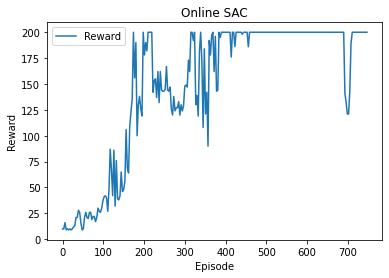

In [5]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 1000
STEPS_PER_EPISODE = 200
env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the online SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` set to None. Also, leave the
#    `use_cql` and `offline` flags to remain False.
# 2) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
# 3) Plot the learning curves.
##########################################################
agent_results = []
online_sac_agent = SACAgent(env, replay_buffer=None, offline=False, use_cql=False)
run_results = []
for episode_number in range(EPISODES_PER_RUN):
    print('\r', f'Episode: {episode_number + 1}/{EPISODES_PER_RUN}', end=' ')
    evaluation_episode = episode_number % TRAINING_EVALUATION_RATIO == 0
    episode_reward = 0
    state = env.reset()
    done = False
    i = 0
    while not done and i < STEPS_PER_EPISODE:
        i += 1
        action = online_sac_agent.get_next_action(state, evaluation_episode=evaluation_episode)
        next_state, reward, done, info = env.step(action)
        if not evaluation_episode:
            online_sac_agent.train_on_transition(state, action, next_state, reward, done)
        else:
            episode_reward += reward
        state = next_state
    if evaluation_episode:
        run_results.append(episode_reward)

env.close()

x_axis = list(range(len(run_results)))
x_axis = [x * (TRAINING_EVALUATION_RATIO - 1) for x in list(range(len(x_axis)))]

plt.plot(x_axis, run_results, label='Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Online SAC')
plt.legend()
plt.show()

## Offline SAC training loop (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

 Epoch: 200/200 

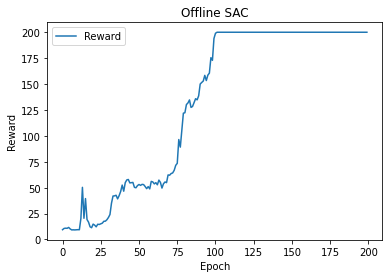

In [7]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
agent_results = []
offline_sac_agent = SACAgent(env, replay_buffer=online_sac_agent.replay_buffer, offline=True, use_cql=False)
average_run_results = []
for epoch in range(NUM_EPOCHS):
    print('\r', f'Epoch: {epoch + 1}/{NUM_EPOCHS}', end=' ')
    #train
    minibatch_size = 1000
    batch_deterministic_start = 0
    while batch_deterministic_start < offline_sac_agent.replay_buffer.count:
        minibatch = offline_sac_agent.replay_buffer.sample_minibatch(minibatch_size, batch_deterministic_start=batch_deterministic_start)
        minibatch_separated = list(map(list, zip(*minibatch)))
        
        states_tensor = torch.tensor(np.array(minibatch_separated[0]))
        actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
        rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
        next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
        done_tensor = torch.tensor(np.array(minibatch_separated[4]))
        
        batch_deterministic_start += minibatch_size
        offline_sac_agent.train_on_transition(states_tensor, actions_tensor, next_states_tensor, rewards_tensor, done_tensor)
    
    
    #validation
    run_results = []
    for episode_number in range(EPISODES_PER_RUN):
        episode_reward = 0
        state = env.reset()
        done = False
        i = 0
        while not done and i < STEPS_PER_EPISODE:
            i += 1
            action = offline_sac_agent.get_next_action(state, evaluation_episode=True)
            next_state, reward, done, info = env.step(action)
            episode_reward += reward
            state = next_state
        run_results.append(episode_reward)
    average_run_results.append(np.mean(run_results))
    

env.close()

x_axis = list(range(len(average_run_results)))

plt.plot(x_axis, average_run_results, label='Reward')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.title('Offline SAC')
plt.legend()
plt.show()

## Conservative SAC training loop (5 points)

Similar to the previous part, you are going to train another offline agent. In this part, you are going to use the conservative version of SAC.

 Epoch: 200/200 

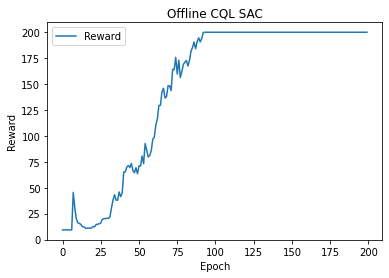

In [13]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (5 points):
# Implement the training loop for the conservative SAC.
# 1) You need to initialize an agent with the current
#    `replay_buffer` of the online agent. Set the `offline`
#     and `use_cql` flags.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
agent_results = []
offline_cql_sac_agent = SACAgent(env, replay_buffer=online_sac_agent.replay_buffer, offline=True, use_cql=True)
average_run_results = []
for epoch in range(NUM_EPOCHS):
    print('\r', f'Epoch: {epoch + 1}/{NUM_EPOCHS}', end=' ')
    #train
    minibatch_size = 1000
    batch_deterministic_start = 0
    while batch_deterministic_start < offline_cql_sac_agent.replay_buffer.count:
        minibatch = offline_cql_sac_agent.replay_buffer.sample_minibatch(minibatch_size, batch_deterministic_start=batch_deterministic_start)
        minibatch_separated = list(map(list, zip(*minibatch)))
        
        states_tensor = torch.tensor(np.array(minibatch_separated[0]))
        actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
        rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
        next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
        done_tensor = torch.tensor(np.array(minibatch_separated[4]))
        
        batch_deterministic_start += minibatch_size
    
        offline_cql_sac_agent.train_on_transition(states_tensor, actions_tensor, next_states_tensor, rewards_tensor, done_tensor)
    
    
    #validation
    run_results = []
    for episode_number in range(EPISODES_PER_RUN):
        episode_reward = 0
        state = env.reset()
        done = False
        i = 0
        while not done and i < STEPS_PER_EPISODE:
            i += 1
            action = offline_cql_sac_agent.get_next_action(state, evaluation_episode=True)
            next_state, reward, done, info = env.step(action)
            episode_reward += reward
            state = next_state
        run_results.append(episode_reward)
    average_run_results.append(np.mean(run_results))
    

env.close()

x_axis = list(range(len(average_run_results)))

plt.plot(x_axis, average_run_results, label='Reward')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.title('Offline CQL SAC')
plt.legend()
plt.show()

## Comparisons (14 points)
Now, analyze your results and justify the trends you see. Then answer the following questions.

❓ What is the reason for the difference between online and offline performance of the agent?
\
✅ In offline setting we have distribution shift and OOD generalization problem (for the Q function part we are getting max of Q function and max acts as an adverserial example in for our estimator and also we maybe do actions that we haven't seen in dataset).

❓ Which one is better: offline SAC or conservative SAC?
\
✅ Conservative SAC. Because it somewhat solves the problem of distribution shift and ood generalization specially the Q function part my git min of it while getting max of policy.

❓ What is the effect of `TRADEOFF_FACTOR` in the offline setting? How does changing its value affect the results?
\
✅ There is a tradeoff for it. The more it is the more conservative the algorithm is and the slower the convergence and the less it is the faster but noisier the convergence.

In [ ]:
#References:
#https://arxiv.org/abs/1812.05905
#https://arxiv.org/abs/1910.07207
#https://github.com/Felhof/DiscreteSAC
#https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/agents/actor_critic_agents
#https://towardsdatascience.com/adapting-soft-actor-critic-for-discrete-action-spaces-a20614d4a50a
#https://arxiv.org/pdf/2006.04779.pdf
#https://github.com/young-geng/CQL